# Detecting loadwords with Keras

### In this notebook you will:
1. Train a neural network using Keras.
1. Optimize hyperparameters for the Neural Net
1. Compare the performance between a Neural Net and a Decision Tree classifier.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [4]:
import logging
import random
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import density
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5

plt.style.use('fivethirtyeight')


Using TensorFlow backend.


## Fix random seed values for reproducibility and tuning
see: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [5]:
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Add parent directory to path so we can access our common code

In [6]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [7]:
from mlyoucanuse.featurize_text_fun import word_to_features

### Turn on logging, primarily so that library methods may report warnings, if any

In [8]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)

## Load the saved X,y matrix 
as created in the `detect_loanwords_problems_solutions` notebook

In [9]:
all_X = None
with open('all_X.pkl', 'rb') as pickle_file:
    all_X = pickle.load(pickle_file)
all_y = None
with open('all_y', 'rb') as pickle_file:
    all_y = pickle.load(pickle_file)

## Create a function to plot the history of the model training and validation

In [10]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Process the saved matrix

In [11]:
scaler = StandardScaler()
# try:  all_X.astype(np.float64)
scaler.fit(all_X.astype(np.float64))
# TODO pickle this scaler for applying the same transforms to input
with open('scaler.pkl', 'wb') as fwriter:
    pickle.dump(scaler, fwriter)    
all_X_scaled = scaler.transform(all_X.astype(np.float64))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_X_scaled, all_y, test_size=0.2, random_state=42)

## Create Keras callbacks as desired

In [13]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=0,
                               mode='auto',
                               baseline=None,
                               restore_best_weights=False)
tensor_board = TensorBoard(log_dir='./logs',
                           histogram_freq=0,
                           batch_size=32,
                           write_graph=True,
                           write_grads=False,
                           write_images=False,
                           embeddings_freq=0,
                           embeddings_layer_names=None,
                           embeddings_metadata=None,
                           embeddings_data=None,
                           update_freq='epoch')

# Create Keras Model

In [37]:
num_features = all_X.shape[1]   

model = Sequential()
model.add(Dense(500, input_dim=num_features, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
# also tried:
#  optimizer='rmsprop' 
# activation='elu'
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 500)               13000     
_________________________________________________________________
dense_20 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 501       
Total params: 264,001
Trainable params: 264,001
Non-trainable params: 0
_________________________________________________________________


In [38]:
 history = model.fit(X_train, y_train,
                     epochs=20,
                     verbose=True,
                     validation_data=(X_test, y_test),
                     batch_size=16,
                     callbacks=[ tensor_board ]
                    )

Train on 181280 samples, validate on 45321 samples
Epoch 1/20
181280/181280 [==============================] - 40s 220us/step - loss: 0.3943 - acc: 0.8330 - val_loss: 0.3330 - val_acc: 0.8600
Epoch 2/20
181280/181280 [==============================] - 40s 219us/step - loss: 0.3001 - acc: 0.8726 - val_loss: 0.2772 - val_acc: 0.8857
Epoch 3/20
181280/181280 [==============================] - 40s 220us/step - loss: 0.2552 - acc: 0.8936 - val_loss: 0.2465 - val_acc: 0.8950
Epoch 4/20
181280/181280 [==============================] - 40s 221us/step - loss: 0.2370 - acc: 0.9010 - val_loss: 0.2491 - val_acc: 0.8963
Epoch 5/20
181280/181280 [==============================] - 39s 218us/step - loss: 0.2272 - acc: 0.9058 - val_loss: 0.2271 - val_acc: 0.9065
Epoch 6/20
181280/181280 [==============================] - 39s 218us/step - loss: 0.2209 - acc: 0.9085 - val_loss: 0.2244 - val_acc: 0.9083
Epoch 7/20
181280/181280 [==============================] - 39s 217us/step - loss: 0.2158 - acc: 0.9115

In [39]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f"Training Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Testing Accuracy: {accuracy:.4f}")

181280/181280 [==============================] - 5s 27us/step
Training Accuracy: 0.9274
45321/45321 [==============================] - 1s 26us/step
Testing Accuracy: 0.9238


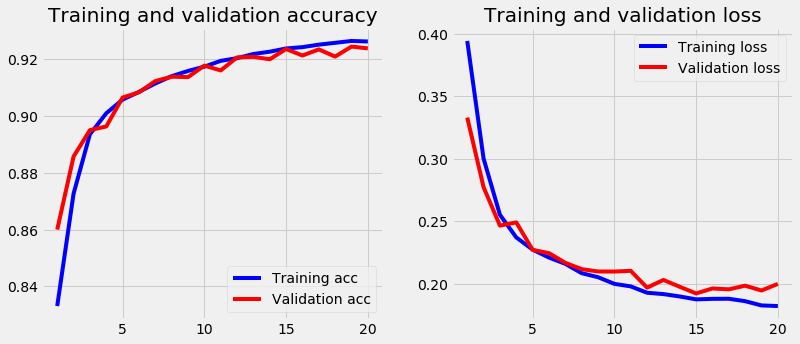

In [40]:
plot_history(history)

## Results of parameter tuning
### 1 Layer
* 800 units, 1 layer, 20 epochs
    * Training Accuracy: 0.8638
    * Testing Accuracy: 0.8606
### 2 Layers
* 800 units, 2 layers, 15 epochs: 92%
    * Training Accuracy: 0.9192 
    * Testing Accuracy: 0.9124
* 1000 units, 25 epochs: 
    * Training Accuracy: 0.9318
    * Testing Accuracy: 0.9251
* 100->50 units, 25 epochs, stopped at:
* 48*25 = 1200 units, 25 epochs using elu
    * Training Accuracy: 0.9055
    * Testing Accuracy: 0.9031
* 1200 units
    * Training Accuracy: 0.9322
    * Testing Accuracy: 0.9253
* 900 units
    * Training Accuracy: 0.9322
    * Testing Accuracy: 0.9242
* 800 units
    * Training Accuracy: 0.9329
    * Testing Accuracy: 0.9266
* 200 units
    * Training Accuracy: 0.9284
    * Testing Accuracy: 0.9217
* 400 units
    * Training Accuracy: 0.9305
    * Testing Accuracy: 0.9227
* 600 units
    * Training Accuracy: 0.9332
    * Testing Accuracy: 0.9272
* 500 units
    * Training Accuracy: 0.9274
    * Testing Accuracy: 0.9238

## Tips for parameter tuning
* Set a seed for random on the Python and library levels, as done early in this notebook
* Be sure to recreate and compile your model fresh with each training session;
    * If you rerun the .fit() method, you’ll start off with the computed weights from the previous training.
* Study the history plots of each run, notice where training and validation characteristically starts to diverge more and more.
    * Your training and validation graphs may have local minima, so you might not be able to use early stopping automatically.


## Train and save with final params

In [41]:
model = Sequential()
model.add(Dense(600, input_dim=num_features, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
model.fit(all_X_scaled, all_y,
                     epochs=17,
                     verbose=False,
                     batch_size=16)
model.save('loanword_detector.greek_latin.keras.h5')  # creates an HDF5 file 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 600)               15600     
_________________________________________________________________
dense_23 (Dense)             (None, 600)               360600    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 601       
Total params: 376,801
Trainable params: 376,801
Non-trainable params: 0
_________________________________________________________________


## Load the model and call it a run time (don't use pickle)

In [42]:
mymodel = load_model('loanword_detector.greek_latin.keras.h5')

In [43]:
def is_greek(word):
    x = [word_to_features(word, max_word_length=25)]
    # Use the fitted transformer, load from a pickle if necessary
    x = scaler.transform(x)
    return mymodel.predict(x)

In [54]:
is_greek('arxomai') 

array([[0.96278566]], dtype=float32)

In [46]:
is_greek('veritas')

array([[0.06464736]], dtype=float32)

In [50]:
is_greek('thuon')

array([[0.99877995]], dtype=float32)

## Comparing the scikit learn classifier vs. the Keras Neural Net
* RandomForest Classifier
    * 1.3 Gigabytes pickle size
    * accuracy: 96%
* Keras Neural Net
    * 4.3 Megabytes h5 size
    * accuracy: 92.7%


# That's all for now folks!